In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
print(os.getcwd())

import numpy as np
import pandas as pd
import random
from scipy import stats
import matplotlib.pyplot as plt

from scandy.models.LocationModel import LocationModel
from scandy.models.ObjectModel import ObjectModel
from scandy.utils.dataclass import Dataset
import scandy.utils.functions as uf

from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution

/beegfs/home/users/n/nicolas-roth/ScanDy


# Model optimization and quantitative comparison

In this example, we show how we can find suitable parameters for a model with evolutionary optimization, such that models can be compared quantitatively. 

## Dataset and model initialization
The parameter optimization should be done on the training set, but for this example we demonstrate how to do this on a single video.

In [17]:
vidlist = sorted(['dance01', 'dance02', 'field03', 'foutain02', 'garden04', 'garden06', 'garden07', 'garden09', 'park01', 'park06', 'park09', 'road02', 'road04', 'road05', 'robarm01', 'room01', 'room02', 'room03', 'tommy02', 'uscdog01', 'walkway01', 'walkway02', 'walkway03'])
random.seed(12345)
# this split is used for the results in the manuscript
trainlist = sorted(random.sample(vidlist, 10))
testlist = sorted([vidname for vidname in vidlist if vidname not in trainlist])
print("trainlist = ", trainlist, "\ntestlist =", testlist)

datadict = {
    "PATH": "/scratch/nroth/VidCom/VidCom/", 
    'FPS' : 30,
    'PX_TO_DVA' : 0.06,
    'FRAMES_ALL_VIDS' : 300,
    'gt_foveation_df' : '2021-12-04_VidCom_GT_fov_df',
    'gt_fovframes_nss_df' : 'gt_fovframes_nss_df.csv',
    'trainset' : trainlist,
    'testset' : testlist,
}
VidCom = Dataset(datadict)

trainlist =  ['dance01', 'dance02', 'garden06', 'garden07', 'park01', 'park06', 'road02', 'road05', 'room01', 'walkway03'] 
testlist = ['field03', 'foutain02', 'garden04', 'garden09', 'park09', 'road04', 'robarm01', 'room02', 'room03', 'tommy02', 'uscdog01', 'walkway01', 'walkway02']


We only run it for a single model here, which is specified by the model family (MODEL) and the saliency information used (FEATURESET). 

In [4]:
MODEL = "obj" # "loc" or "obj"
# we can vary the saliency map, "molin" corresponds to low-level features
FEATURESET = "molin" # "molin", "TASEDnet" (high-level), or "None" (center bias only)

## Implement the fitness function

With this information, we can specify the model we want to investigate. The parameters are then selected for each run based on the evolutionary optimization strategy. 

But before we specify the parameter space, we define an optimization function, which we will pass to the `Evolution` class from `neurolib` (powered by the `deap` and `pypet` libraries).

In [5]:
# ground truth summary statistics from the training set, this is used to evaluate the fitness
gt_amp_dva = VidCom.train_foveation_df["sac_amp_dva"].dropna().values
gt_dur_ms = VidCom.train_foveation_df["duration_ms"].dropna().values
 

def optimize_me(traj):
    ind = evolution.getIndividualFromTraj(traj)
    # create model of the given model family
    if MODEL == "obj":
        model = ObjectModel(VidCom)
    elif MODEL == "loc":
        model = LocationModel(VidCom)
    else:
        raise Exception(f"The only implemented models here are obj and loc!")
    model.params["centerbias"] = "anisotropic_default"
    model.params["featuretype"] = FEATURESET
    # free model parameters, varied in evolution
    model.params["ddm_thres"] = ind.ddm_thres
    model.params["ddm_sig"] = ind.ddm_sig
    model.params["att_dva"] = ind.att_dva
    model.params["ior_decay"] = ind.ior_decay
    # IOR parameters depend on the model...
    if MODEL == "obj":
        model.params["ior_inobj"] = ind.ior_inobj
    else:
        model.params["ior_dva"] = ind.ior_dva

    # usually run model on all videos of the training set for multiple random seeds
    # model.run("train", seeds=[s for s in range(1, 13)])
    # ...but for demonstration purposes, we only run the model on one video once:
    model.run("field03", seeds=[s for s in [1]])

    model.evaluate_all_to_df()  # creates model.result_df
    sim_dur_ms = model.result_df["duration_ms"].dropna().values
    sim_amp_dva = model.result_df["sac_amp_dva"].dropna().values

    # evaluate fitness
    ks_amp, _ = stats.ks_2samp(gt_amp_dva, sim_amp_dva)
    ks_dur, _ = stats.ks_2samp(gt_dur_ms, sim_dur_ms)
    fitness_tuple = (ks_dur, ks_amp)

    # we can store more information in the HDF file by returning a dictionary
    res_dict = model.get_fovcat_ratio()
    
    return fitness_tuple, res_dict

## Specify parameters and run optimization

We can now specify the parameter space for the optimization. We use the `ParameterSpace` class from `neurolib` to give a range for all free model parameters.

In [18]:
obj_pars = ParameterSpace(
    ["ddm_thres", "ddm_sig", "att_dva", "ior_decay", "ior_inobj"],
    [[1.0, 3.0], [0.05, 0.25], [5, 20], [30, 300], [0.4, 1.0]],
)

Now we have everything set up to actually run the evolutionary optimization. As specified in `optimize_me`, we only run it for one video and one random seed. 

The processes are parallelized if your system allows for it. With eight cores, this optimization should take less than 5 minutes.

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/ex2_obj_sglvid.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x7f215cdd6d40>
MainProcess root INFO     Evolution: Mating operator: <function cxBlend at 0x7f2160ef95f0>
MainProcess root INFO     Evolution: Mutation operator: <function gaussianAdaptiveMutation_nStepSizes at 0x7f215cb2d200>
MainProcess root INFO     Evolution: Parent selection: <function selRank at 0x7f215cdd6ef0>
MainProcess root INFO     Evolution: Selection operator: <function selBest_multiObj at 0x7f215cdd6f80>
MainProcess root INFO     Evaluating initial population of size 16 ...
MainProcess pypet.trajectory.Trajectory INFO     Your trajectory has not been explored, yet. I will call `f_explore` instead.
MainProcess pypet.enviro

Parameter distribution (Generation 0):
ddm_thres: 	 mean: 1.9318,	 std: 0.5216
ddm_sig: 	 mean: 0.1342,	 std: 0.0531
att_dva: 	 mean: 11.1663,	 std: 4.4342
ior_decay: 	 mean: 165.3481,	 std: 80.1768
ior_inobj: 	 mean: 0.7347,	 std: 0.1594


MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `derived_parameters`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished storing Trajectory `results-2023-03-13-18H-10M-21S`.
MainProcess root INFO     Start of evolution
MainProcess root INFO     Replacing 0 invalid individuals.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2023-03-13-18H-10M

----------- Generation 1 -----------
Best individual is [1.4157901819506824, 0.14771648443266872, 11.760108691762031, 168.06094917811907, 0.713882055784139, 0.6060955130641998, 0.08492127230017639, 4.935663186192262, 70.37338429364084, 0.17858428713570926]
Score: -0.1543184562605683
Fitness: (0.1968178332785628, 0.11181907924257381)
--- Population statistics ---
> Simulation parameters
HDF file storage: ./data/hdf/ex2_obj_sglvid.hdf
Trajectory Name: results-2023-03-13-18H-10M-21S
Duration of evaluating initial population 0:00:35.534989
Eval function: <function optimize_me at 0x7f215c74c3b0>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 5
Initial population size: 16
Population size: 8
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f2160ef95f0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f215cd

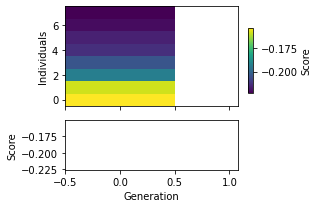

MainProcess root INFO     Saving plot to ./data/figures/results-2023-03-13-18H-10M-21S_hist_1.png


There are 8 valid individuals
Mean score across population: -0.2


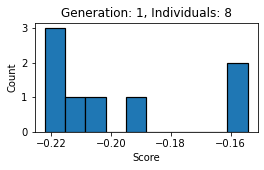

<Figure size 432x288 with 0 Axes>

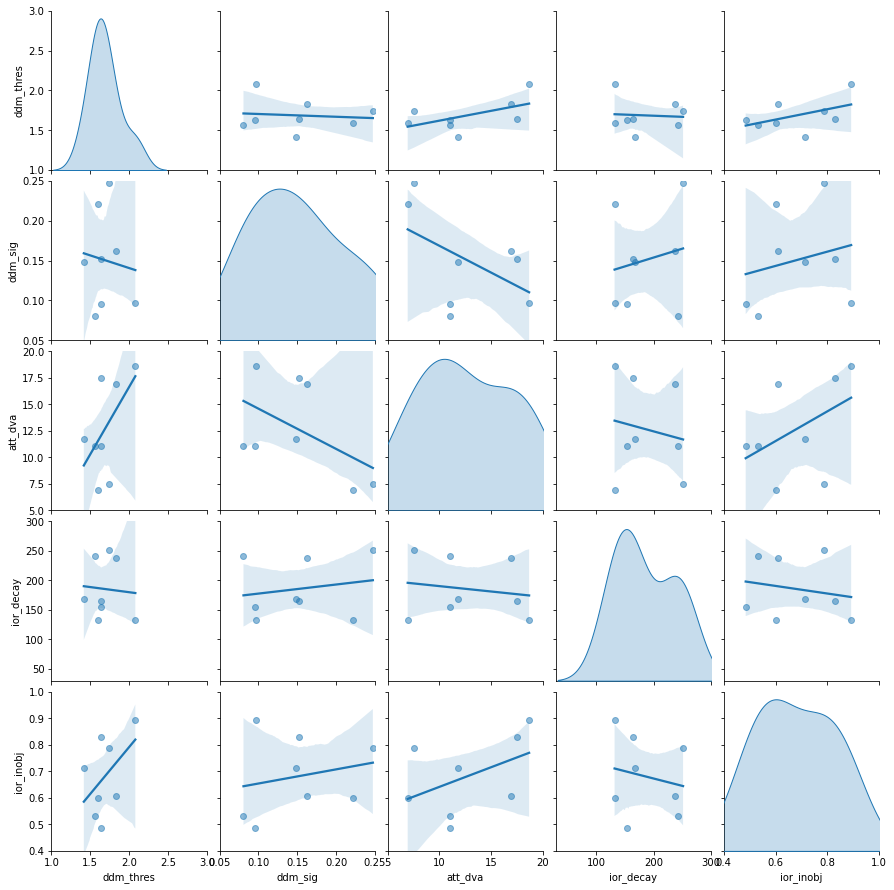

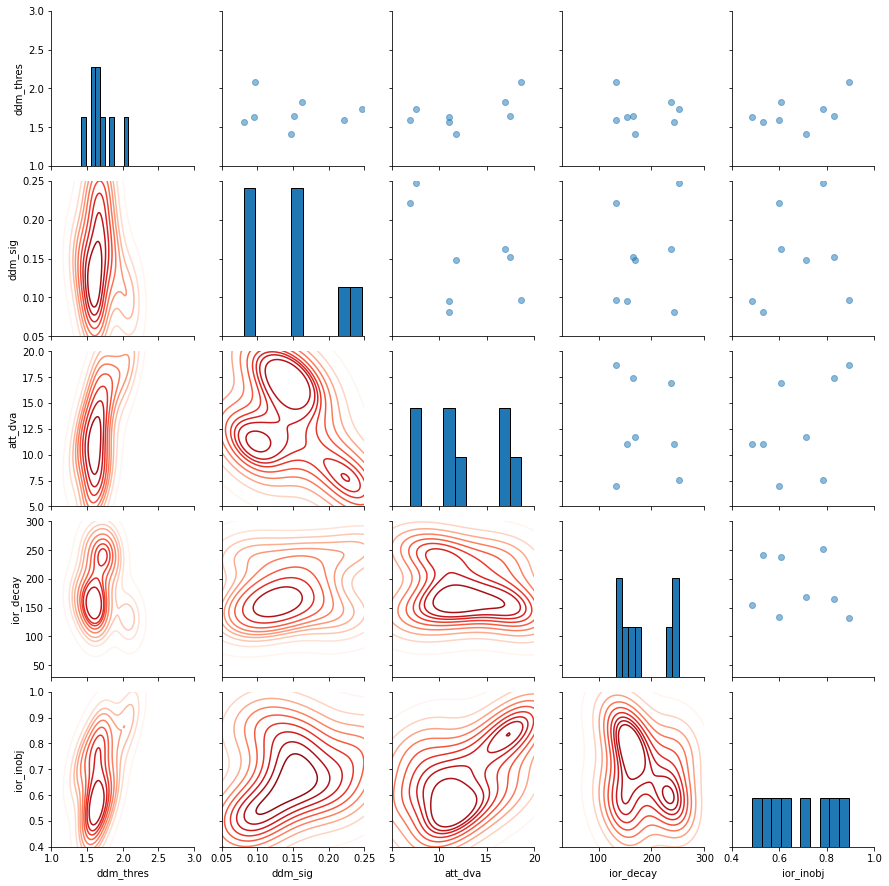

MainProcess root INFO     Replacing 0 invalid individuals.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2023-03-13-18H-10M-21S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.storageservice.HDF5StorageS

----------- Generation 2 -----------
Best individual is [1.9389486647712966, 0.0744997739905217, 11.053433414511705, 178.76068573556074, 0.5510465549438067, 0.42004469556380447, 0.04061683139510476, 2.0134007644239, 63.623239603872506, 0.1947643073875814]
Score: -0.11522379560233822
Fitness: (0.13966480446927373, 0.09078278673540273)
--- Population statistics ---
> Simulation parameters
HDF file storage: ./data/hdf/ex2_obj_sglvid.hdf
Trajectory Name: results-2023-03-13-18H-10M-21S
Duration of evaluating initial population 0:00:35.534989
Eval function: <function optimize_me at 0x7f215c74c3b0>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 5
Initial population size: 16
Population size: 8
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f2160ef95f0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f215c

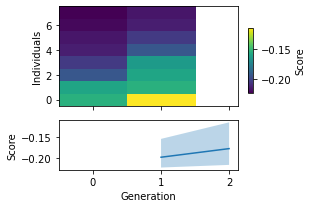

MainProcess root INFO     Saving plot to ./data/figures/results-2023-03-13-18H-10M-21S_hist_2.png


There are 8 valid individuals
Mean score across population: -0.18


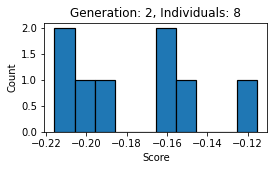

<Figure size 432x288 with 0 Axes>

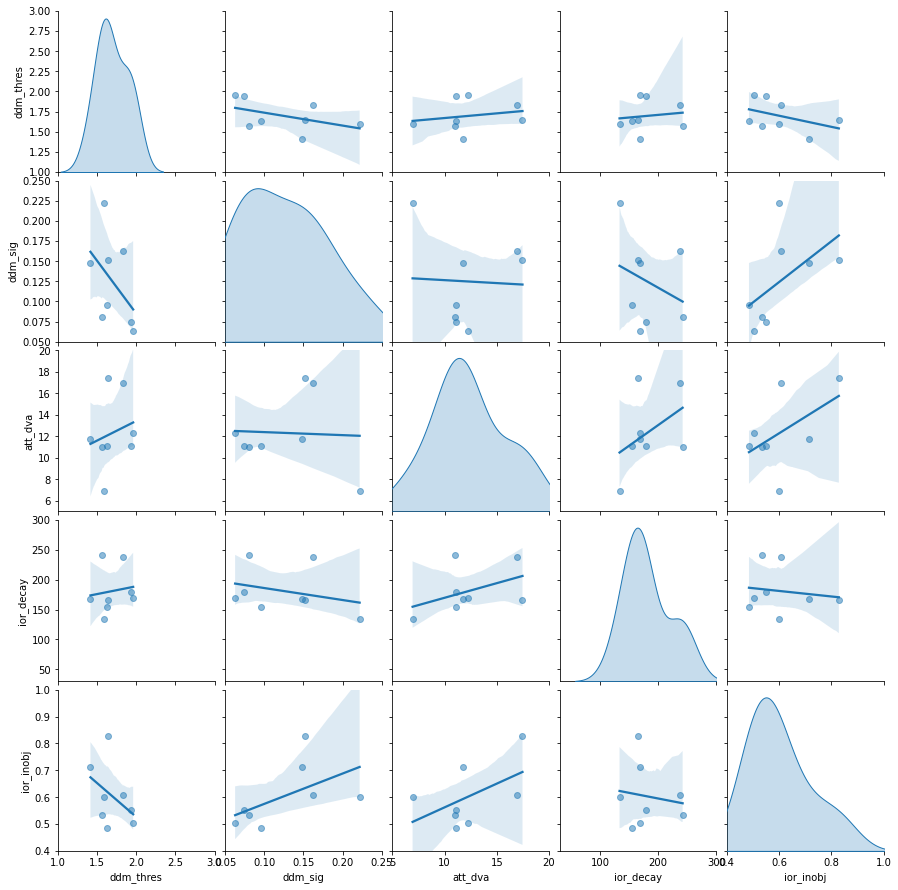

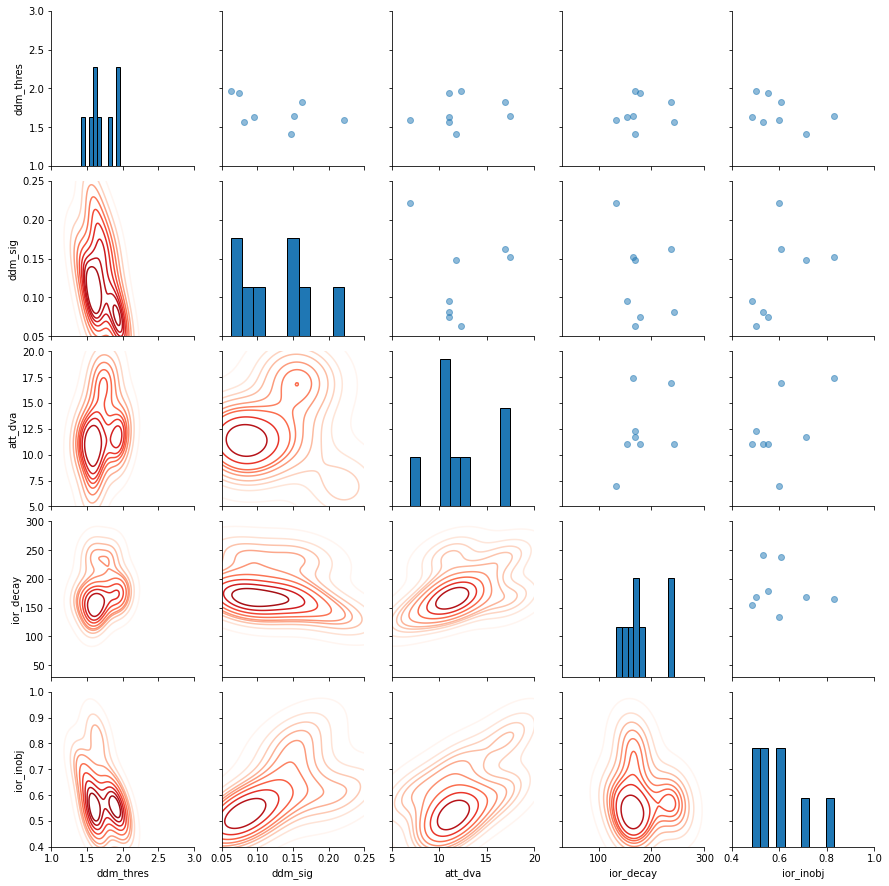

MainProcess root INFO     Replacing 0 invalid individuals.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2023-03-13-18H-10M-21S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.storageservice.HDF5StorageS

----------- Generation 3 -----------
Best individual is [1.9389486647712966, 0.0744997739905217, 11.053433414511705, 178.76068573556074, 0.5510465549438067, 0.42004469556380447, 0.04061683139510476, 2.0134007644239, 63.623239603872506, 0.1947643073875814]
Score: -0.11522379560233822
Fitness: (0.13966480446927373, 0.09078278673540273)
--- Population statistics ---
> Simulation parameters
HDF file storage: ./data/hdf/ex2_obj_sglvid.hdf
Trajectory Name: results-2023-03-13-18H-10M-21S
Duration of evaluating initial population 0:00:35.534989
Eval function: <function optimize_me at 0x7f215c74c3b0>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 5
Initial population size: 16
Population size: 8
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f2160ef95f0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f215c

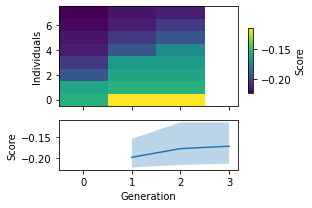

MainProcess root INFO     Saving plot to ./data/figures/results-2023-03-13-18H-10M-21S_hist_3.png


There are 8 valid individuals
Mean score across population: -0.17


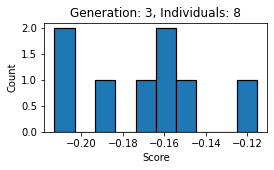

<Figure size 432x288 with 0 Axes>

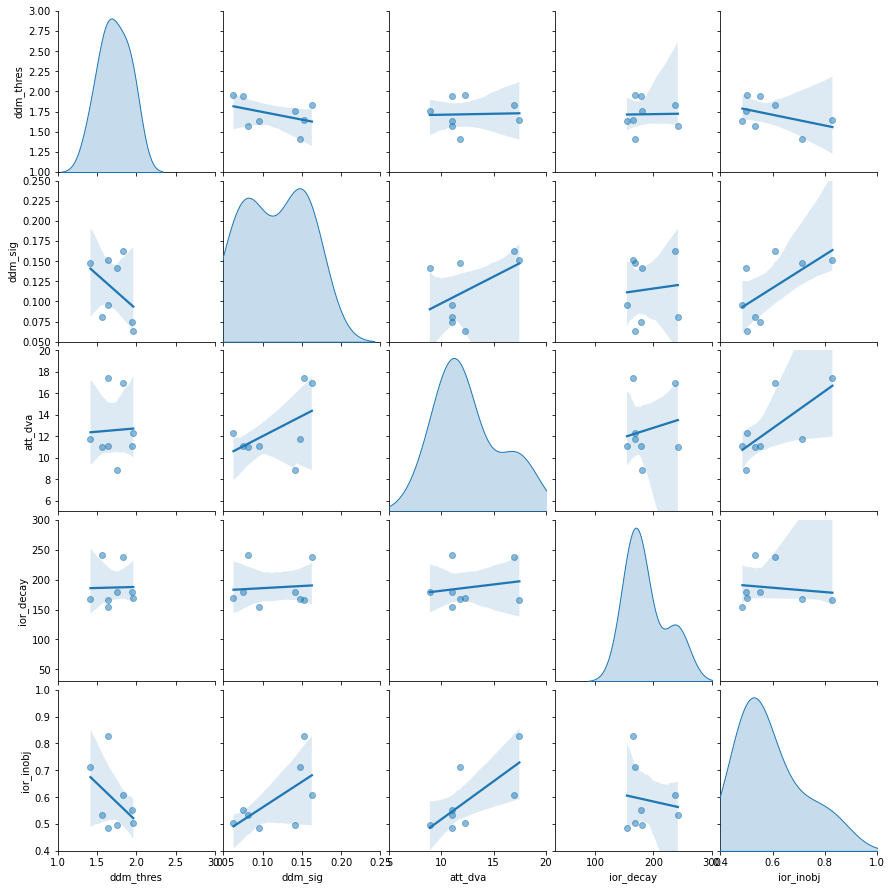

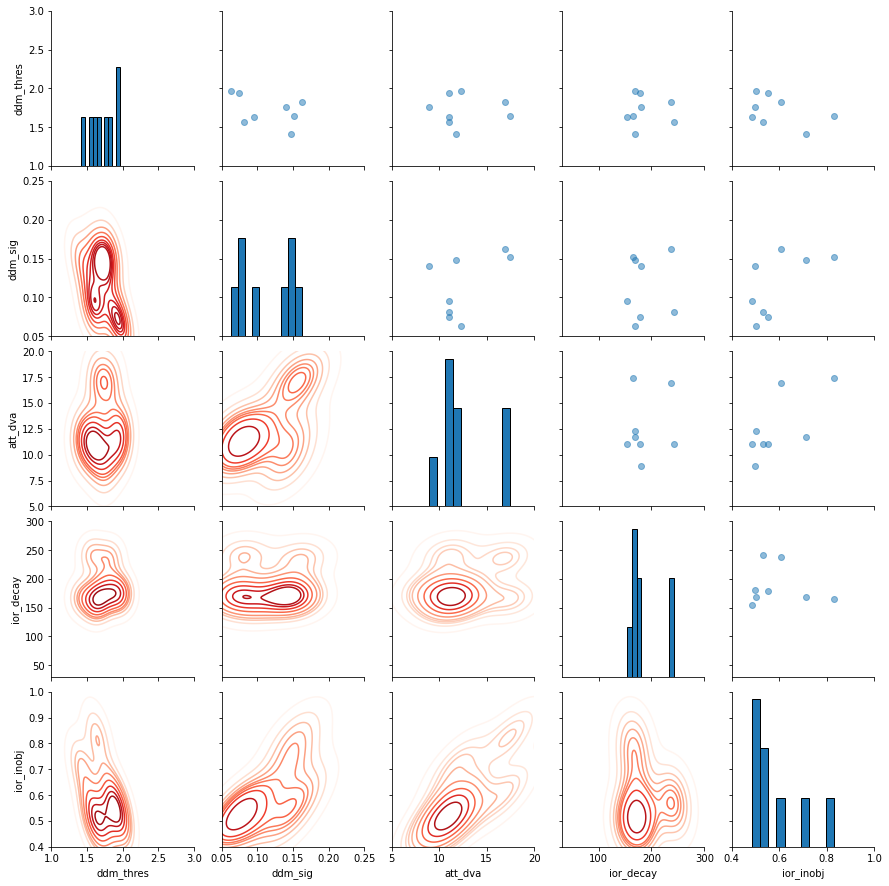

MainProcess root INFO     Replacing 0 invalid individuals.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2023-03-13-18H-10M-21S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.storageservice.HDF5StorageS

----------- Generation 4 -----------
Best individual is [1.9389486647712966, 0.0744997739905217, 11.053433414511705, 178.76068573556074, 0.5510465549438067, 0.42004469556380447, 0.04061683139510476, 2.0134007644239, 63.623239603872506, 0.1947643073875814]
Score: -0.11522379560233822
Fitness: (0.13966480446927373, 0.09078278673540273)
--- Population statistics ---
> Simulation parameters
HDF file storage: ./data/hdf/ex2_obj_sglvid.hdf
Trajectory Name: results-2023-03-13-18H-10M-21S
Duration of evaluating initial population 0:00:35.534989
Eval function: <function optimize_me at 0x7f215c74c3b0>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 5
Initial population size: 16
Population size: 8
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f2160ef95f0>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f215c

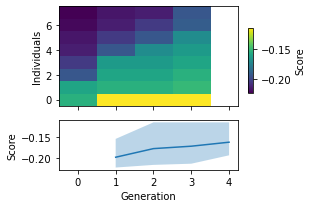

MainProcess root INFO     Saving plot to ./data/figures/results-2023-03-13-18H-10M-21S_hist_4.png


There are 8 valid individuals
Mean score across population: -0.16


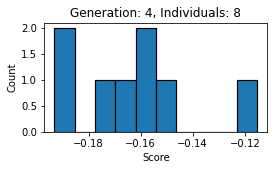

<Figure size 432x288 with 0 Axes>

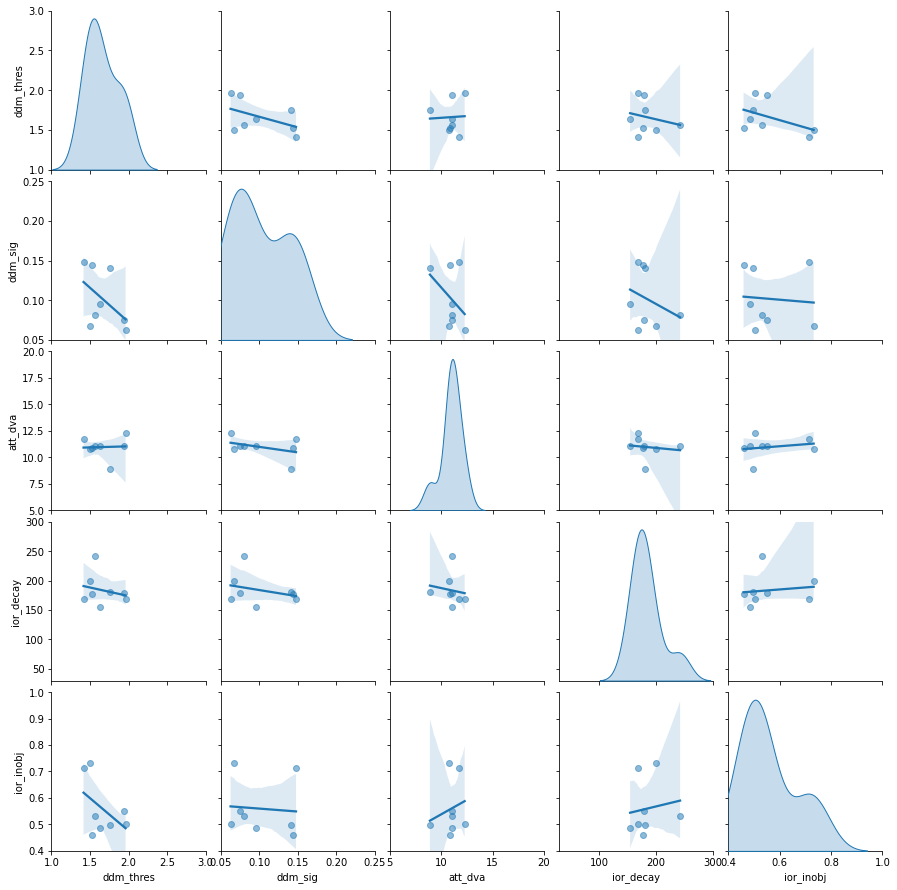

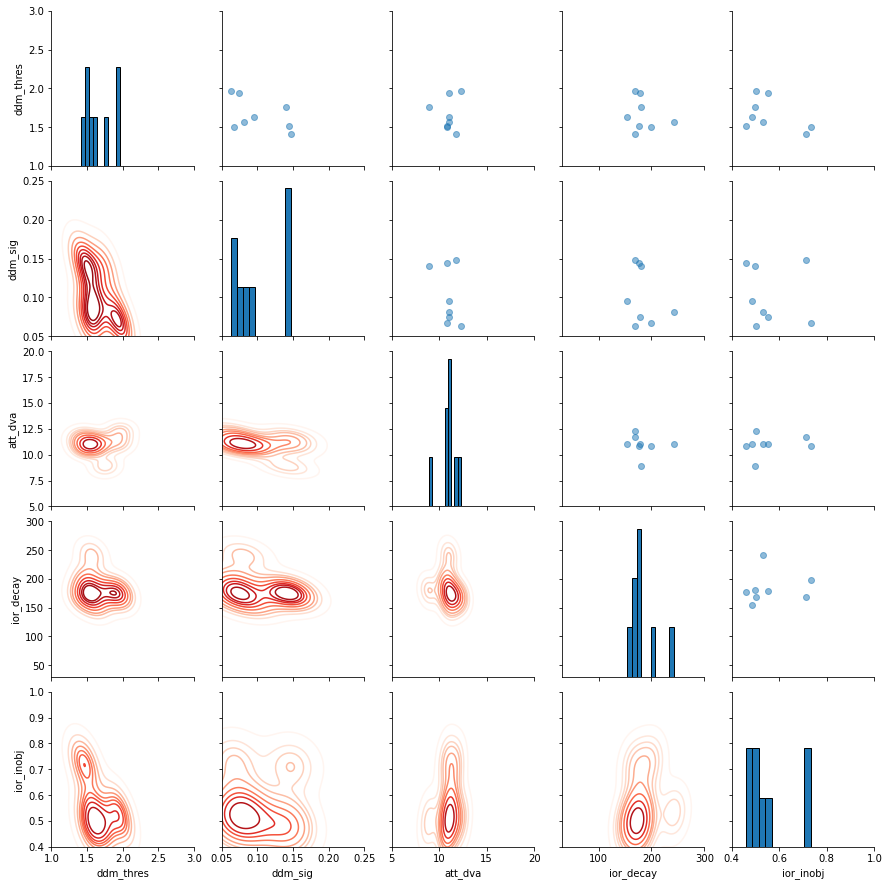

MainProcess root INFO     --- End of evolution ---
MainProcess root INFO     Best individual is [1.9389486647712966, 0.0744997739905217, 11.053433414511705, 178.76068573556074, 0.5510465549438067, 0.42004469556380447, 0.04061683139510476, 2.0134007644239, 63.623239603872506, 0.1947643073875814], (0.13966480446927373, 0.09078278673540273)
MainProcess root INFO     --- End of evolution ---
MainProcess pypet.storageservice.HDF5StorageService INFO     Start storing Trajectory `results-2023-03-13-18H-10M-21S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `config`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `parameters`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `results`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `derived_parameters`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished storing Trajectory `results-2023-03-13-18H-10M-21S`.


In [7]:
evolution = Evolution(
    optimize_me,
    obj_pars,
    weightList=[-1.0, -1.0], #weights foveation duration and saccade amplitude equally
    filename="ex2_obj_sglvid.hdf",
    POP_INIT_SIZE=16,  # better: 64
    POP_SIZE=8,  # better: 32
    NGEN=5,  # better: 50
)
# verbose means it creates multiple plots for each generation
evolution.run(verbose = True)

Usually, this evolution would be run on all videos of the trainingset, with multiple seeds, higher population sizes and for more generations. Hence, this typically runs best on a high-performance computing cluster.

The results can be saved in a DILL file with the following command:

In [ ]:
evolution.saveEvolution("saved_evolution_ex2_obj_sglvid.dill")

## Further analysis / functional evaluation

To actually evaluate how well the simulated scanpaths correspond to human exploration behavior, we recommend to look into the functional scanpath comparison. The basis of this are the ratios of time that are spent in each foveation category, which we saved in this example in the result dictionary. 

The outputs from the evolution in the hdf file can be accessed in in a convenient way as pandas DataFrame:

In [16]:
df_evol = evolution.dfEvolution(outputs=True)
# show the tree best parameter combinations with their fitness score and the stored results 
df_evol.sort_values(by=["score"], ascending=False).iloc[0:3]

,ddm_thres,ddm_sig,att_dva,ior_decay,ior_inobj,score,id,gen,B,D,I,R,f0,f1
23,1.938949,0.074500,11.053433,178.760686,0.551047,-0.115224,31,2,0.86,0.036667,0.103333,0.00,0.139665,0.090783
39,1.500495,0.067191,10.798734,198.943095,0.732462,-0.150645,47,4,0.63,0.080000,0.230000,0.06,0.195804,0.105486
14,1.415790,0.147716,11.760109,168.060949,0.713882,-0.154318,22,1,0.56,0.046667,0.393333,0.00,0.196818,0.111819


For a more in depth analysis of the foveation categories, please refer to the `manuscript_results.ipynb` notebook, where the full analysis is shown in detail.